# Submitting Multiple Circuits in One Job

Sometimes we want to execute multiple circuits on a single backend. `shots` are usually how we handle having the same circuit execute multiple times on the backend, but we cannot rely on that when we want to send multiple circuits that are not the exact same. Many users' first thought is to send multiple jobs.

In [1]:
# Set up imports, IBMQ account, and backend
from qiskit import QuantumCircuit, execute, IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

backend = provider.get_backend('ibmq_qasm_simulator')

In [7]:
# Create 2 circuits
circuit_1 = QuantumCircuit(2, 2)
circuit_1.h(0)
circuit_1.cx(0, 1)
circuit_1.measure([0, 1], [0, 1])

circuit_2 = QuantumCircuit(2, 2)
circuit_2.h(1)
circuit_2.cx(1, 0)
circuit_2.measure([0, 1], [0, 1])

# Submit a job for each circuit
job_1 = execute(circuit_1, backend)
job_2 = execute(circuit_2, backend)

print("Job 1: {}".format(job_1.result().get_counts(circuit_1)))
print("Job 2: {}".format(job_2.result().get_counts(circuit_2)))

Job 1: {'11': 513, '00': 511}
Job 2: {'11': 517, '00': 507}


However, when needing to send hundreds of different circuits, creating hundreds of jobs will be very expensive, and the increased overhead will have the user waiting a large amount of time to receive all of their reuslts

## Encapsulating multiple circuits into one job

It is possible to send include multiple circuits into one job. 

In [4]:
# Set up imports, IBMQ account, and backend
from qiskit import QuantumCircuit, execute, IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')

backend = provider.get_backend('ibmq_qasm_simulator')

/anaconda3/envs/qiskit_env/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


In [10]:
circuit_list = []  # This will be what we send with our job

# Create 2 circuits
circuit_1 = QuantumCircuit(2, 2)
circuit_1.h(0)
circuit_1.cx(0, 1)
circuit_1.measure([0, 1], [0, 1])

circuit_2 = QuantumCircuit(2, 2)
circuit_2.h(1)
circuit_2.cx(1, 0)
circuit_2.measure([0, 1], [0, 1])

# Add both circuits to the list
circuit_list.append(circuit_1)
circuit_list.append(circuit_2)

In [11]:
# Submit a single job that contains both circuits
job = execute(circuit_list, backend)

## Retrieving outputs from a job containing multiple circuits

When retrieving outputs from an executed circuit, you usually just need to call `job.result().get_counts(<circuit_name>)`. However, we have multiple circuits to retrieve results for. Luckily, even in this case, you can still retrieve the results for all of the circuits from `job.result()`

There are a couple of ways of doing this:

In [13]:
results = job.result()

# Option 1: Use the circuit name
circuit_1_counts = results.get_counts(circuit_1)
circuit_2_counts = results.get_counts(circuit_2)

print("Circuit 1 using circuit name: {}".format(circuit_1_counts))
print("Circuit 2 using circuit name: {}".format(circuit_2_counts))

# Option 2: Use the list index
circuit_1_counts = results.get_counts(circuit_list[0])
circuit_2_counts = results.get_counts(circuit_list[1])

print("Circuit 1 using list index: {}".format(circuit_1_counts))
print("Circuit 2 using list index: {}".format(circuit_2_counts))

Circuit 1 using circuit name: {'11': 512, '00': 512}
Circuit 2 using circuit name: {'11': 532, '00': 492}
Circuit 1 using list index: {'11': 512, '00': 512}
Circuit 2 using list index: {'11': 532, '00': 492}


## Advantages of sending multiple circuits in one job

There are impactful advantages to using this method. The most important one is **runtime**. There is some overhead with each individual job that is processed. So, obviously, sending one job as opposed to many would minimize this overhead. It also prevents your jobs from being buried in the queue. If you are sending hundreds of jobs, the overhead is going to add up, and some of these jobs may be scattered throughout the queue.

We can show the difference in time taken by using both methods to run the same circuit multiple time. Let's take an example of 50 circuits.

In [3]:
import time
circuit_list = []
total_time_taken_individual = 0      # This will be the total runtime for the individual job method
total_execution_time_individual = 0  # This will be the total execution time for the individual job method

for __ in range(5):
    # Create a new circuit
    qc = QuantumCircuit(2, 2)
    qc.h(0)
    qc.cx(0, 1)
    qc.measure([0, 1], [0, 1])
    
    # Add the circuit to circuit_list
    circuit_list.append(qc)
    
    # Execute the circuit in its own individual job and get total time taken
    start_time = time.time()
    job_individual = execute(qc, backend)
    if job_individual.result():  # Once job has finished executing get end time
        end_time = time.time()

    total_time_taken_individual += (end_time - start_time)
    
    # Retrieve time_taken executing and add to total time taken
    total_execution_time_individual += job_individual.result().time_taken
    
# Create single job and execute, and get total time taken
start_time = time.time()
job_bundled = execute(circuit_list, backend)
if job_bundled.result():  # Once job has finished executing get end time
    end_time = time.time()

total_time_taken_bundled = (end_time - start_time)
total_execution_time_bundled = job_bundled.result().time_taken

# Compare execution time and total time taken between the two methods. Round to 5 decimal places.
print("Total execution time with individual jobs: {} seconds".format(round(total_execution_time_individual, 5)))
print("Total execution time with a single job:    {} seconds".format(round(total_execution_time_bundled, 5)))
print("Total time taken with individual jobs:     {} seconds".format(round(total_time_taken_individual, 5)))
print("Total time taken with a single job:        {} seconds".format(round(total_time_taken_bundled, 5)))

Total execution time with individual jobs: 0.02238 seconds
Total execution time with a single job:    0.0195 seconds
Total time taken with individual jobs:     31.5369 seconds
Total time taken with a single job:        7.34314 seconds


As you can see, there are large differences in total execution time and total runtime between the two methods, with the circuit bundling method coming out ahead. 

## Viewing bundled circuit job results on IBM Q Experience

Viewing bundled circuit jobs' results will look different on IBM Q Experience. Since there are multiple circuits in the job, there are multiple sets of results to view. When viewing the results page of one of these jobs, you will see a page similar to the one below. It will have a dropdown menu of each circuit within the job, and you can click through them to view the results of each.

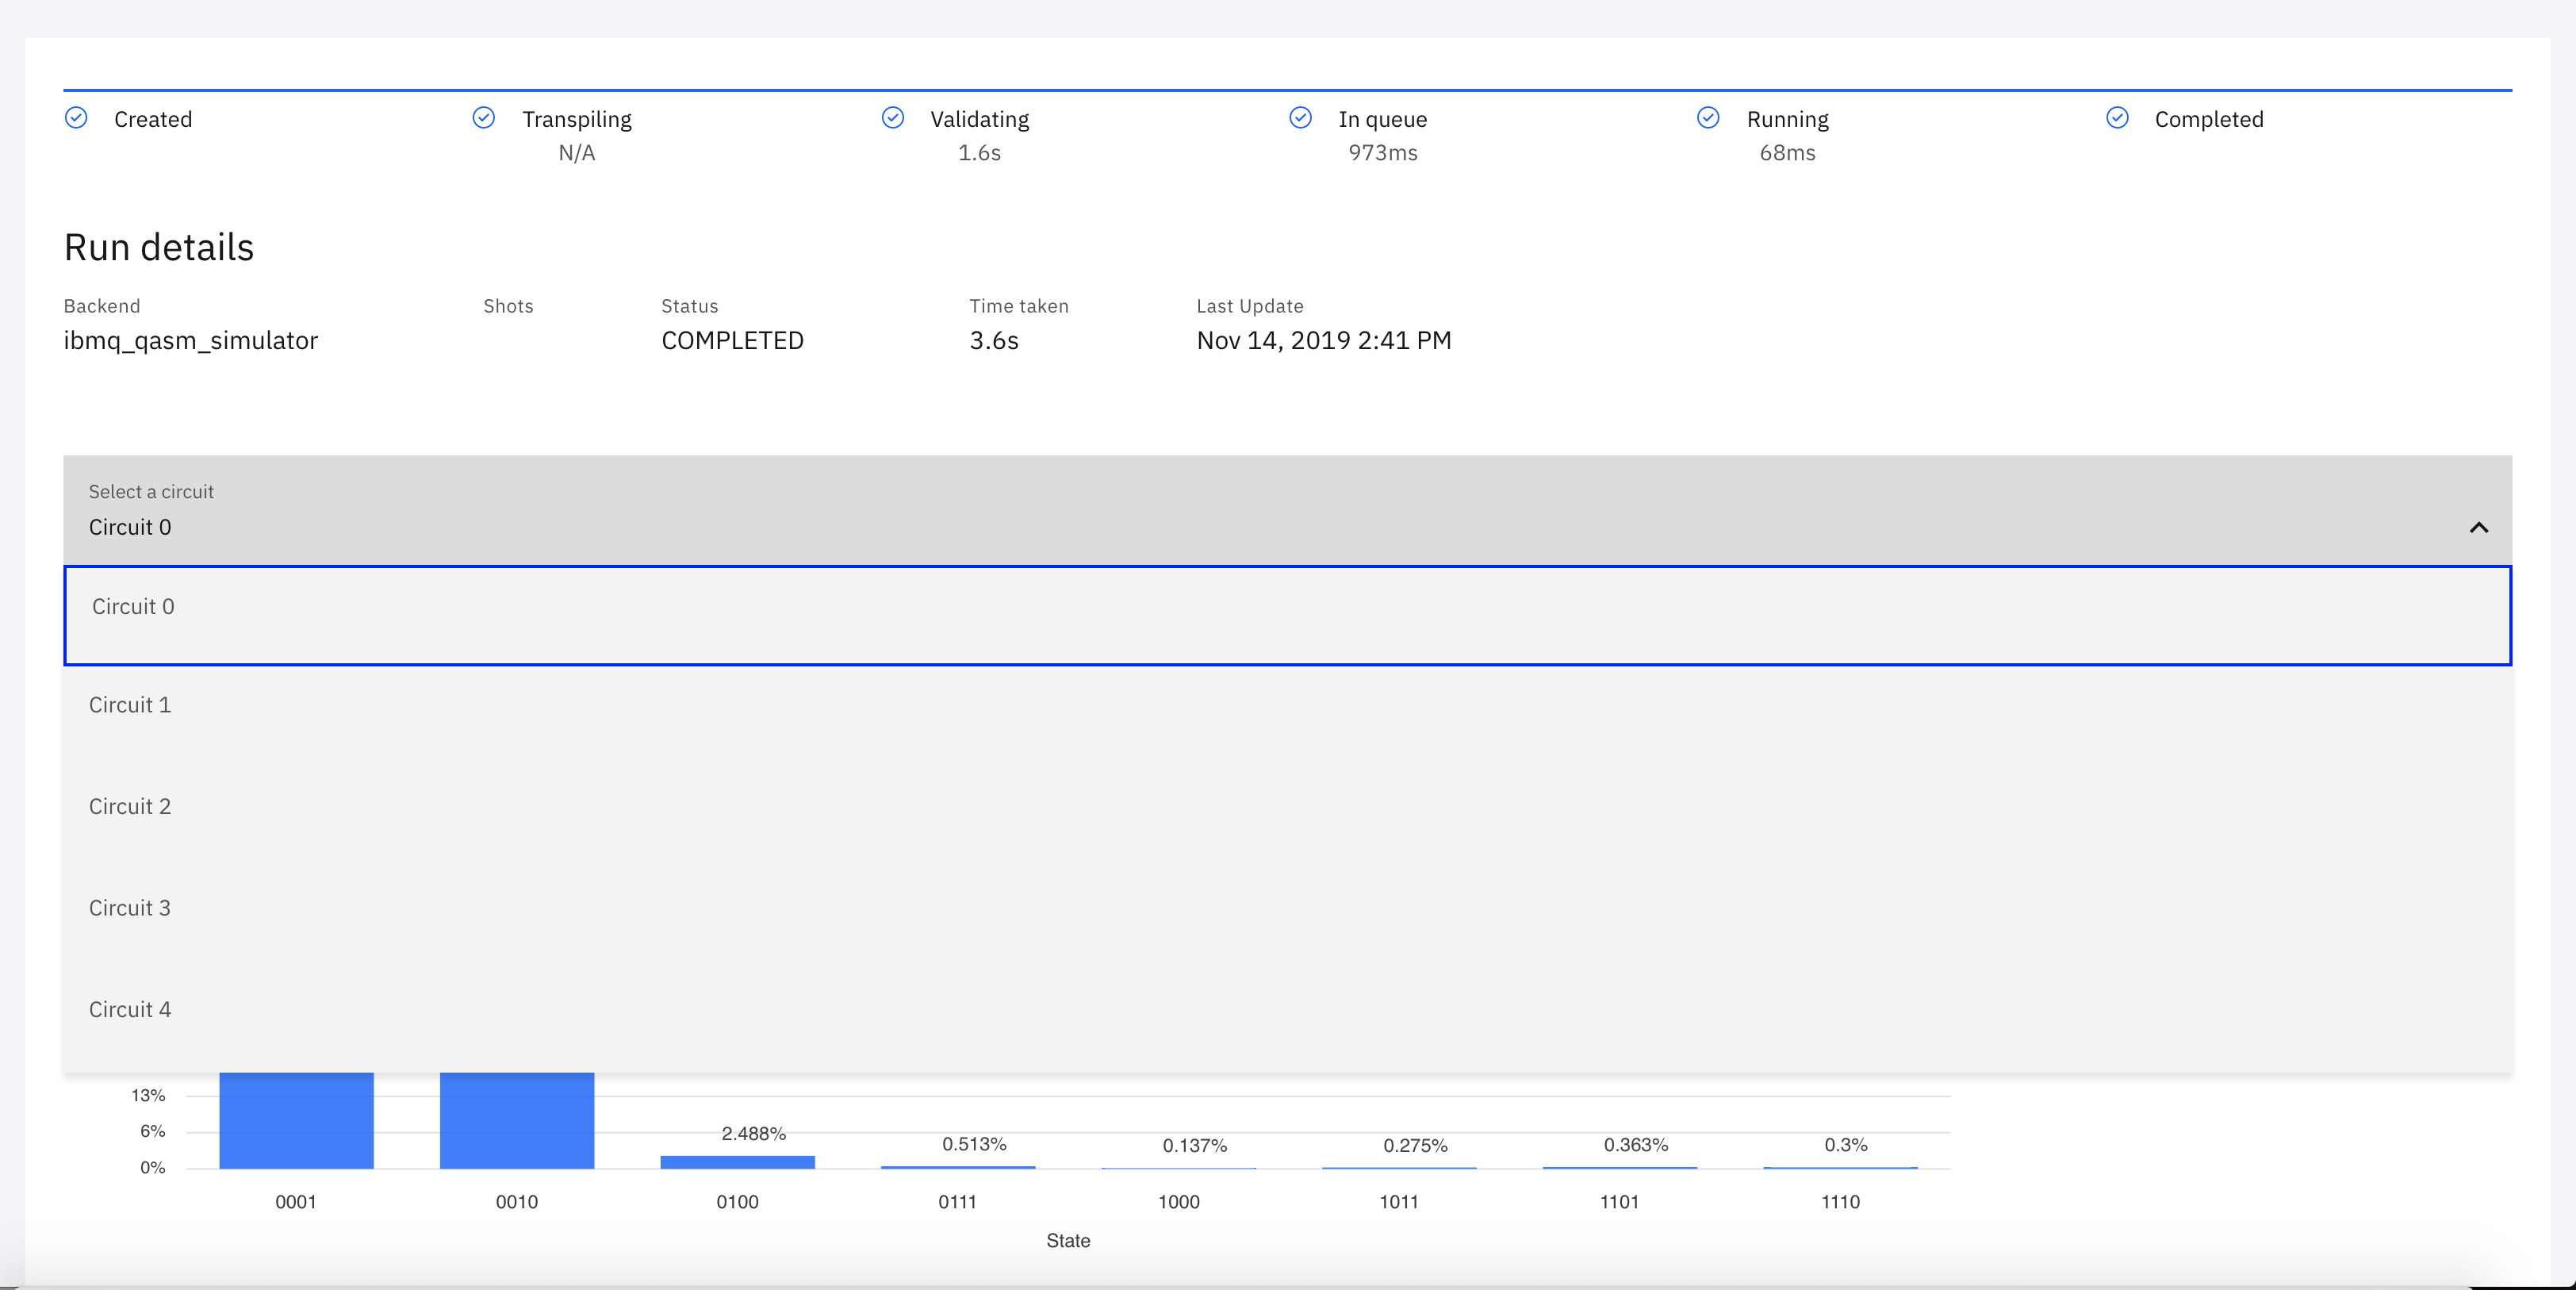